## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-08-19 00:50:03.655366: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 00:50:03.733813: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-19 00:50:06.036365: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Load Processed Data

In [2]:
try:
    data = pd.read_csv('../data/adj_close.csv', index_col=0, parse_dates=True)
    if isinstance(data.columns, pd.MultiIndex):
        new_cols = []
        for col_tuple in data.columns:
            if 'TSLA' in col_tuple:
                new_cols.append('TSLA')
            elif 'BND' in col_tuple:
                new_cols.append('BND')
            elif 'SPY' in col_tuple:
                new_cols.append('SPY')
            else:
                new_cols.append('_'.join(map(str, col_tuple)).replace('UNNAMED: ', '').replace('_LEVEL_2', ''))
        data.columns = new_cols
        data = data[['TSLA', 'BND', 'SPY']]
    print("Data loaded successfully from adj_close.csv!")
except Exception as e:
    print(f"Error loading data from adj_close.csv: {e}")
    try:
        raw_data = pd.read_csv('../data/financial_data.csv', header=[0, 1], index_col=0, parse_dates=True)
        data = raw_data['Adj Close']
        data.columns = ['BND', 'SPY', 'TSLA']
        print("Successfully re-extracted 'Adj Close' from 'financial_data.csv'.")
    except Exception as e_fallback:
        print(f"Fallback failed: {e_fallback}. Cannot proceed without proper data.")
        exit()


Data loaded successfully from adj_close.csv!


## TSLA - Forecasting

In [ ]:
data.columns = ['BND', 'SPY', 'TSLA']

tsla_data = data[['TSLA']].copy()

train_start_date = '2015-07-01'
train_end_date = '2023-12-31'
test_start_date = '2024-01-01'
test_end_date = '2025-07-31'

train_data = tsla_data[train_start_date:train_end_date]
test_data = tsla_data[test_start_date:test_end_date]

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n--- {model_name} Model Evaluation ---")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    return mae, rmse, mape

print("\n--- Retraining LSTM Model for Future Forecasting ---")



--- Retraining LSTM Model for Future Forecasting ---


## Data Scaling for LSTM

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
full_scaled_data = scaler.fit_transform(tsla_data)

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 60

X_full, y_full = create_sequences(full_scaled_data, sequence_length)

X_full = np.reshape(X_full, (X_full.shape[0], X_full.shape[1], 1))

lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_full.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(X_full, y_full,
                         epochs=100,
                         batch_size=32,
                         callbacks=[early_stopping],
                         verbose=1)

print("\n--- LSTM Model Retraining Complete ---")


## Forecast Future Market Trends


--- Generating Future Forecasts (12 Months) ---


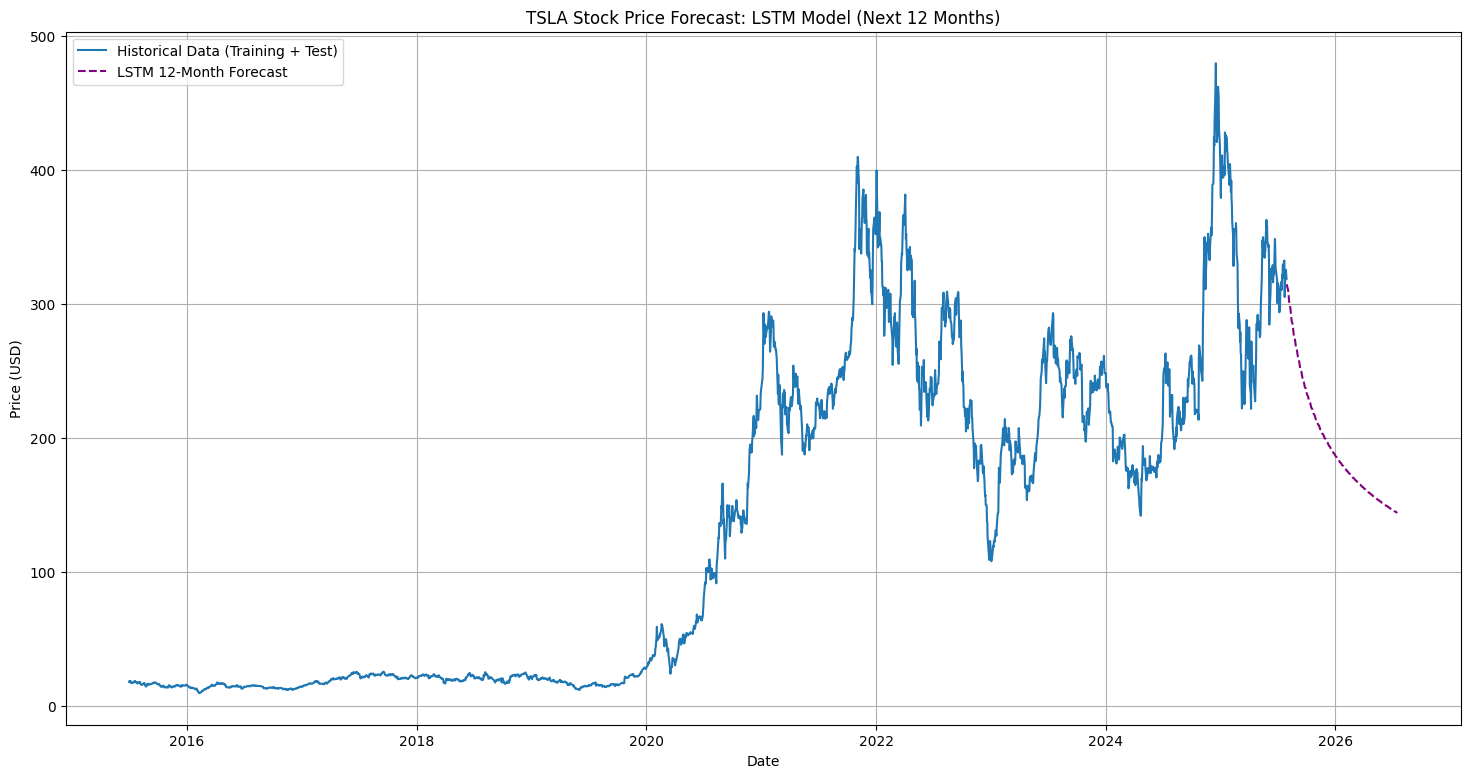


--- Future Forecast Generation Complete ---
First 5 future forecast prices:
2025-07-31    314.821228
2025-08-01    313.079224
2025-08-04    310.631836
2025-08-05    307.935883
2025-08-06    305.180756
Freq: B, dtype: float32

Last 5 future forecast prices:
2026-07-13    144.949966
2026-07-14    144.745224
2026-07-15    144.541321
2026-07-16    144.338257
2026-07-17    144.136032
Freq: B, dtype: float32


In [ ]:


print("\n--- Generating Future Forecasts (12 Months) ---")

future_forecast_days = 252

last_sequence = full_scaled_data[-sequence_length:]

future_predictions_scaled = []
current_batch = last_sequence.reshape((1, sequence_length, 1))

for i in range(future_forecast_days):
    next_day_prediction = lstm_model.predict(current_batch, verbose=0)[0]
    future_predictions_scaled.append(next_day_prediction)

    current_batch = np.append(current_batch[:, 1:, :], [[next_day_prediction]], axis=1)

future_forecast_prices = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

last_known_date = tsla_data.index[-1]
future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=future_forecast_days, freq='B') # 'B' for business day frequency

future_forecast_series = pd.Series(future_forecast_prices.flatten(), index=future_dates[:len(future_forecast_prices)])

plt.figure(figsize=(18, 9))
plt.plot(tsla_data['TSLA'], label='Historical Data (Training + Test)')
plt.plot(future_forecast_series, label='LSTM 12-Month Forecast', color='purple', linestyle='--')
plt.title('TSLA Stock Price Forecast: LSTM Model (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Future Forecast Generation Complete ---")
print("First 5 future forecast prices:")
print(future_forecast_series.head())
print("\nLast 5 future forecast prices:")
print(future_forecast_series.tail())
